In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

# Raw code
  - paper's code

In [2]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data,torch.tensor(labels)

In [3]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

In [4]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

* model architecture

In [5]:
device = torch.device("cuda",0)
model = newModel().to(device)

print(model)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('total param cnt : {:,}'.format(params))

newModel(
  (embedding): Embedding(24, 512, padding_idx=0)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=Fals

# 1. Make Data X_train, y_train, X_test, y_test

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
df_detect_peptide_test = pd.read_csv('data/df_detect_peptide_test.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('compareModel/2021ACS_PepFormer/detect_peptide_train.csv', header=False, index=False)
val.to_csv('compareModel/2021ACS_PepFormer/detect_peptide_val.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('compareModel/2021ACS_PepFormer/detect_peptide_test.csv', header=False, index=False)

In [8]:
train_data,train_label=genData("compareModel/2021ACS_PepFormer/detect_peptide_train.csv",81)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("compareModel/2021ACS_PepFormer/detect_peptide_val.csv",81)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("compareModel/2021ACS_PepFormer/detect_peptide_test.csv",81)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 81: 0
torch.Size([543516, 30]) torch.Size([543516])
length > 81: 0
torch.Size([135880, 30]) torch.Size([135880])
length > 81: 0
torch.Size([133992, 30]) torch.Size([133992])


In [10]:
import seaborn as sns

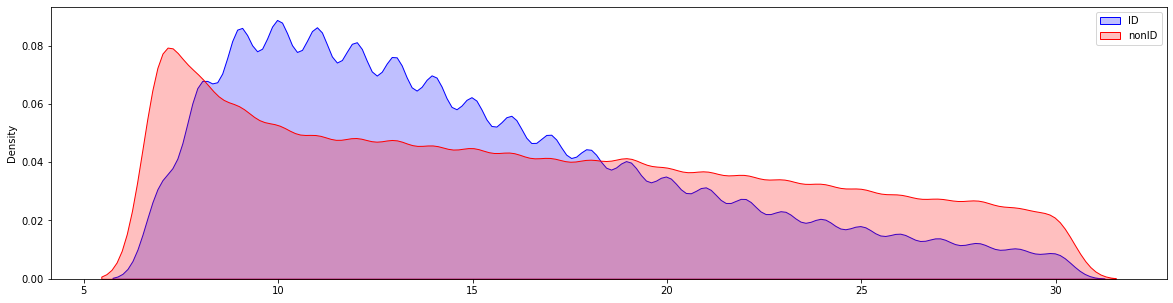

In [11]:
viz = pd.concat([tra, val, df_detect_peptide_test], axis=0).reset_index(drop=True)
p = viz.loc[viz.ID==1]
n = viz.loc[viz.ID==0]
pl = p.PEP.apply(lambda x: len(x)).values
nl = n.PEP.apply(lambda x: len(x)).values
plt.figure(figsize=(20,5))
sns.kdeplot(pl, shade=True, color='blue')
sns.kdeplot(nl, shade=True, color='red')
plt.legend(['ID', 'nonID'])
plt.show()

# 2. train

In [46]:
len(train_iter_cont)

2124

In [45]:
for idx, (s1, s2, l, l1, l2) in enumerate(train_iter_cont):
    if idx == 1:
        break
    print(s1, s2, l, l1, l2)
    print(s1.shape, s2.shape, l.shape, l1.shape, l2.shape)

tensor([[17,  7,  1,  ...,  0,  0,  0],
        [17,  4, 13,  ...,  0,  0,  0],
        [11, 11,  3,  ...,  0,  0,  0],
        ...,
        [10, 10, 17,  ...,  0,  0,  0],
        [17, 21, 19,  ...,  0,  0,  0],
        [ 7,  8, 21,  ...,  2,  0,  0]], device='cuda:0') tensor([[14,  6,  7,  ...,  0,  0,  0],
        [22,  1, 11,  ...,  0,  0,  0],
        [ 9,  8,  2,  ...,  0,  0,  0],
        ...,
        [12,  5,  5,  ...,  0,  0,  0],
        [11, 12,  3,  ...,  0,  0,  0],
        [22, 19, 12,  ...,  0,  0,  0]], device='cuda:0') tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0') tensor([

In [9]:
for num_model in range(1):  # just one train
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(val_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        to_log(results)
        if test_acc>best_acc:
            best_acc=test_acc
            torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 140.84746, loss1: 1.19428, loss2_3: 139.65318
	train_acc: 0.7731, test_acc: 0.7734177215189874, time: 332.49
best_acc: 0.7734177215189874
epoch: 2, loss: 121.71362, loss1: 0.91124, loss2_3: 120.80238
	train_acc: 0.7872, test_acc: 0.7877318221960553, time: 365.53
best_acc: 0.7877318221960553
epoch: 3, loss: 116.74230, loss1: 0.88208, loss2_3: 115.86022
	train_acc: 0.7965, test_acc: 0.7964306741242273, time: 351.82
best_acc: 0.7964306741242273
epoch: 4, loss: 114.73431, loss1: 0.86472, loss2_3: 113.86959
	train_acc: 0.7735, test_acc: 0.7722549308213129, time: 234.55
epoch: 5, loss: 113.26465, loss1: 0.85201, loss2_3: 112.41264
	train_acc: 0.8044, test_acc: 0.804820429790992, time: 240.00
best_acc: 0.804820429790992
epoch: 6, loss: 112.22021, loss1: 0.84106, loss2_3: 111.37915
	train_acc: 0.8051, test_acc: 0.8045407712687666, time: 240.45
epoch: 7, loss: 111.53184, loss1: 0.83383, loss2_3: 110.69801
	train_acc: 0.8063, test_acc: 0.806623491315867, time: 239.12
best_acc: 0.

epoch: 58, loss: 103.10676, loss1: 0.77044, loss2_3: 102.33631
	train_acc: 0.8212, test_acc: 0.819171327642037, time: 240.95
epoch: 59, loss: 102.97545, loss1: 0.76907, loss2_3: 102.20638
	train_acc: 0.8228, test_acc: 0.8202678834265529, time: 242.79
epoch: 60, loss: 103.01616, loss1: 0.76986, loss2_3: 102.24630
	train_acc: 0.8237, test_acc: 0.8215042684721814, time: 241.11
best_acc: 0.8215042684721814
epoch: 61, loss: 102.91095, loss1: 0.77033, loss2_3: 102.14062
	train_acc: 0.8236, test_acc: 0.8209964674712982, time: 240.87
epoch: 62, loss: 102.87082, loss1: 0.77063, loss2_3: 102.10019
	train_acc: 0.8234, test_acc: 0.8205622608183691, time: 241.53
epoch: 63, loss: 102.82795, loss1: 0.77162, loss2_3: 102.05633
	train_acc: 0.8157, test_acc: 0.813033559022667, time: 241.21
epoch: 64, loss: 102.77581, loss1: 0.76938, loss2_3: 102.00644
	train_acc: 0.8236, test_acc: 0.8208051221666176, time: 240.61
epoch: 65, loss: 102.77077, loss1: 0.76951, loss2_3: 102.00126
	train_acc: 0.8199, test_acc

epoch: 118, loss: 101.62623, loss1: 0.76462, loss2_3: 100.86160
	train_acc: 0.8264, test_acc: 0.8211142184280247, time: 193.65
epoch: 119, loss: 101.71768, loss1: 0.76275, loss2_3: 100.95493
	train_acc: 0.8252, test_acc: 0.8218575213423609, time: 194.40
epoch: 120, loss: 101.71164, loss1: 0.76317, loss2_3: 100.94847
	train_acc: 0.8257, test_acc: 0.8216808949072711, time: 192.87
epoch: 121, loss: 101.64692, loss1: 0.76565, loss2_3: 100.88127
	train_acc: 0.8249, test_acc: 0.8210774212540477, time: 194.66
epoch: 122, loss: 101.61697, loss1: 0.76412, loss2_3: 100.85285
	train_acc: 0.8257, test_acc: 0.8217839269944068, time: 193.14
epoch: 123, loss: 101.61907, loss1: 0.76249, loss2_3: 100.85658
	train_acc: 0.8250, test_acc: 0.8204886664704151, time: 194.62
epoch: 124, loss: 101.54680, loss1: 0.76354, loss2_3: 100.78325
	train_acc: 0.8228, test_acc: 0.8184942596408595, time: 192.49
epoch: 125, loss: 101.52912, loss1: 0.76328, loss2_3: 100.76584
	train_acc: 0.8262, test_acc: 0.822144539299381

epoch: 178, loss: 100.86659, loss1: 0.75977, loss2_3: 100.10683
	train_acc: 0.8286, test_acc: 0.8231159846923757, time: 207.24
epoch: 179, loss: 100.91205, loss1: 0.76101, loss2_3: 100.15105
	train_acc: 0.8258, test_acc: 0.8205328230791875, time: 326.09
epoch: 180, loss: 100.84381, loss1: 0.75867, loss2_3: 100.08514
	train_acc: 0.8269, test_acc: 0.8220415072122461, time: 319.75
epoch: 181, loss: 100.90234, loss1: 0.76125, loss2_3: 100.14109
	train_acc: 0.8276, test_acc: 0.8229687959964674, time: 305.52
epoch: 182, loss: 100.73185, loss1: 0.76162, loss2_3: 99.97023
	train_acc: 0.8285, test_acc: 0.822887842213718, time: 207.60
epoch: 183, loss: 100.82039, loss1: 0.75949, loss2_3: 100.06090
	train_acc: 0.8269, test_acc: 0.8203782749484839, time: 203.59
epoch: 184, loss: 100.81674, loss1: 0.76028, loss2_3: 100.05646
	train_acc: 0.8257, test_acc: 0.820091256991463, time: 203.62
epoch: 185, loss: 100.84560, loss1: 0.75998, loss2_3: 100.08562
	train_acc: 0.8258, test_acc: 0.8208713570797763, 

epoch: 239, loss: 100.47868, loss1: 0.75752, loss2_3: 99.72116
	train_acc: 0.8271, test_acc: 0.8214895496025906, time: 144.38
epoch: 240, loss: 100.52788, loss1: 0.75679, loss2_3: 99.77108
	train_acc: 0.8277, test_acc: 0.8215042684721814, time: 138.11
epoch: 241, loss: 100.40382, loss1: 0.75638, loss2_3: 99.64744
	train_acc: 0.8272, test_acc: 0.8206211362967324, time: 140.82
epoch: 242, loss: 100.57007, loss1: 0.75856, loss2_3: 99.81152
	train_acc: 0.8277, test_acc: 0.8217397703856344, time: 146.61
epoch: 243, loss: 100.42579, loss1: 0.75892, loss2_3: 99.66687
	train_acc: 0.8274, test_acc: 0.8209449514277304, time: 139.79
epoch: 244, loss: 100.52116, loss1: 0.75880, loss2_3: 99.76236
	train_acc: 0.8293, test_acc: 0.8222107742125405, time: 138.89
epoch: 245, loss: 100.36369, loss1: 0.75682, loss2_3: 99.60687
	train_acc: 0.8292, test_acc: 0.8232631733882838, time: 138.42
epoch: 246, loss: 100.34957, loss1: 0.75785, loss2_3: 99.59172
	train_acc: 0.8274, test_acc: 0.8209817486017074, time:

# 3. test

In [12]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [53]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
#         print(outputs.argmax(dim=1),
#              outputs.argmax(dim=1)==y,
#              (outputs.argmax(dim=1)==y).float(),
#              (outputs.argmax(dim=1)==y).float().sum(),
#              (outputs.argmax(dim=1)==y).float().sum().item())
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [14]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [21]:
net = newModel().to(device)
net.load_state_dict(torch.load(f'compareModel/2021ACS_PepFormer/Model/0.pl')['model'])

<All keys matched successfully>

In [22]:
net.eval()

newModel(
  (embedding): Embedding(24, 512, padding_idx=0)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=Fals

In [23]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
embedding.weight 	 torch.Size([24, 512])
encoder_layer.self_attn.in_proj_weight 	 torch.Size([1536, 512])
encoder_layer.self_attn.in_proj_bias 	 torch.Size([1536])
encoder_layer.self_attn.out_proj.weight 	 torch.Size([512, 512])
encoder_layer.self_attn.out_proj.bias 	 torch.Size([512])
encoder_layer.linear1.weight 	 torch.Size([2048, 512])
encoder_layer.linear1.bias 	 torch.Size([2048])
encoder_layer.linear2.weight 	 torch.Size([512, 2048])
encoder_layer.linear2.bias 	 torch.Size([512])
encoder_layer.norm1.weight 	 torch.Size([512])
encoder_layer.norm1.bias 	 torch.Size([512])
encoder_layer.norm2.weight 	 torch.Size([512])
encoder_layer.norm2.bias 	 torch.Size([512])
transformer_encoder.layers.0.self_attn.in_proj_weight 	 torch.Size([1536, 512])
transformer_encoder.layers.0.self_attn.in_proj_bias 	 torch.Size([1536])
transformer_encoder.layers.0.self_attn.out_proj.weight 	 torch.Size([512, 512])
transformer_encoder.layers.0.self_attn.out_proj.bias 	 torch.Size([512]

In [36]:
y_pred = []
for x, y in test_iter:
    x,y=x.to(device),y.to(device)
    outputs=net.trainModel(x)
    print(outputs)
    print(outputs.argmax(dim=1),
         outputs.argmax(dim=1)==y,
         (outputs.argmax(dim=1)==y).float(),
         (outputs.argmax(dim=1)==y).float().sum(),
         (outputs.argmax(dim=1)==y).float().sum().item())
    for _ in outputs.argmax(dim=1):
        y_pred.append(int(_))

tensor([[-1.0207,  0.8635],
        [-1.5367,  1.4383],
        [-1.4003,  1.5337],
        [-1.0240,  1.0634],
        [ 0.6836, -0.8407],
        [-0.4408,  0.3577],
        [-0.7938,  0.9358],
        [-0.2605,  0.1054],
        [-1.0409,  1.1111],
        [-1.3182,  1.2202],
        [-0.7445,  0.2405],
        [-0.5158,  0.4949],
        [-0.1386,  0.1847],
        [-0.3580,  0.3760],
        [-1.2942,  1.5173],
        [-0.2897,  0.0366],
        [-0.3807,  0.2631],
        [-1.5435,  1.4316],
        [-0.5801,  0.6248],
        [-0.2601,  0.2680],
        [-1.3393,  1.4145],
        [-1.6730,  1.8550],
        [-1.6974,  1.6101],
        [-0.3321,  0.0283],
        [-1.1141,  1.0054],
        [ 0.2717, -0.4083],
        [ 0.0118,  0.5355],
        [-1.6467,  1.5275],
        [-0.5261,  0.5138],
        [-1.1569,  1.3433],
        [-0.9170,  0.6371],
        [-0.4980,  0.9801],
        [ 0.3870, -0.0970],
        [-0.2444,  0.1643],
        [-0.6825,  0.4089],
        [-1.0184,  1

tensor([[-1.7804,  2.0154],
        [-1.1717,  0.5181],
        [-0.3224,  0.3991],
        [-1.5081,  1.5414],
        [-0.7375,  0.3293],
        [-0.1246,  0.0325],
        [-1.5536,  1.5659],
        [-1.7347,  1.9029],
        [-1.7723,  1.7617],
        [-0.9758,  1.0571],
        [ 0.0919, -0.2114],
        [-1.7421,  1.7346],
        [-1.3850,  1.0488],
        [-1.4552,  1.3841],
        [-0.6086,  0.4865],
        [-1.7573,  1.8698],
        [-1.6069,  1.8232],
        [-1.6154,  1.7694],
        [-0.6036,  0.4423],
        [-0.4158,  0.3419],
        [-1.1864,  1.2276],
        [-0.3942,  0.5662],
        [-0.4330, -0.1308],
        [-1.7109,  1.7405],
        [ 0.1145, -0.6932],
        [-1.4315,  1.7001],
        [-0.9141,  1.0864],
        [-1.2437,  1.2423],
        [-0.8564,  1.0044],
        [-0.9356,  0.7106],
        [ 0.0149,  0.3210],
        [-1.5873,  1.7173],
        [ 0.2903, -0.6939],
        [-0.0797, -0.0784],
        [-0.4132,  0.6435],
        [-1.5636,  1

tensor([[-7.1643e-01,  1.0608e+00],
        [-7.5809e-01,  2.8771e-01],
        [-1.7937e+00,  1.7731e+00],
        [-2.2071e-01,  1.8079e-01],
        [-1.5245e+00,  1.5710e+00],
        [-1.8122e+00,  1.8996e+00],
        [-1.6231e+00,  1.6425e+00],
        [-1.5865e+00,  1.7091e+00],
        [ 9.4553e-01, -6.0084e-01],
        [-1.6599e+00,  1.6189e+00],
        [-1.1498e+00,  1.1031e+00],
        [-1.6313e+00,  1.7894e+00],
        [ 9.8565e-01, -1.0363e+00],
        [-4.3258e-01,  5.1141e-01],
        [-1.8218e+00,  1.9178e+00],
        [-7.9250e-01,  3.7268e-01],
        [-1.7591e+00,  1.8212e+00],
        [-1.1440e+00,  1.0345e+00],
        [-1.2294e+00,  9.3974e-01],
        [-4.3515e-01,  1.0688e+00],
        [-2.8438e-01,  3.8585e-01],
        [-3.4465e-02,  3.9848e-02],
        [-1.6091e+00,  1.6176e+00],
        [-1.2324e+00,  1.1732e+00],
        [-1.1800e+00,  1.4379e+00],
        [-6.4396e-01,  8.1833e-01],
        [-9.8085e-01,  6.0996e-01],
        [ 2.7028e-01, -1.798

tensor([[-1.4639,  1.4484],
        [-0.8674,  1.0076],
        [-1.7634,  1.8359],
        [-1.6054,  1.7275],
        [-0.7920,  0.5799],
        [-1.5561,  1.5201],
        [ 1.3646, -1.0517],
        [-1.6909,  1.7532],
        [-1.7239,  1.7283],
        [-0.3321,  0.2353],
        [-0.9285,  0.8307],
        [-1.1867,  1.3802],
        [-0.0418,  0.0095],
        [-0.7643,  0.2578],
        [-0.7121,  0.6459],
        [-1.2497,  1.1190],
        [-1.3186,  1.2401],
        [-0.7811,  0.1484],
        [-1.1863,  1.3093],
        [-0.8289,  0.7724],
        [-0.4297,  0.5230],
        [-1.6121,  1.6782],
        [-1.3243,  1.3727],
        [-1.1628,  1.0190],
        [-1.6033,  1.3566],
        [-1.5204,  1.6305],
        [-0.4743,  1.0782],
        [-1.2612,  1.2600],
        [-0.8201,  0.7355],
        [-0.7406,  0.8325],
        [-1.0571,  0.8545],
        [-0.3420, -0.1301],
        [-1.6735,  1.9851],
        [ 0.0478, -0.3720],
        [-1.4621,  1.7586],
        [-0.2272,  0

tensor([[ 0.0353, -0.0716],
        [-0.2091,  0.1406],
        [-0.2521, -0.0046],
        [-0.2700,  0.7334],
        [-0.7455,  0.5247],
        [-0.5249,  0.7728],
        [-1.7286,  1.6592],
        [-1.5510,  1.6541],
        [-1.4866,  1.6323],
        [-1.0151,  0.8806],
        [-1.7424,  1.6708],
        [ 0.0310, -0.0788],
        [-0.9555,  0.8526],
        [-0.8997,  1.2851],
        [-1.6333,  1.5806],
        [-0.5729,  0.8745],
        [-1.7768,  1.8980],
        [-0.8641,  0.6656],
        [ 0.2947, -0.1442],
        [-0.9916,  0.9292],
        [-1.7813,  1.9109],
        [-0.2739,  0.3187],
        [-1.3601,  1.3686],
        [-1.0555,  1.0280],
        [-1.2083,  1.0999],
        [-0.3490, -0.2191],
        [-0.3865,  0.4505],
        [-1.6913,  1.8807],
        [-1.2994,  1.4669],
        [-1.4315,  1.0551],
        [ 0.0433, -0.0757],
        [-0.5350,  0.6654],
        [-1.0576,  0.9819],
        [-0.6567,  0.8191],
        [-1.6056,  1.7464],
        [-0.0722,  0

tensor([[-5.5198e-01,  5.0000e-01],
        [-1.2566e+00,  1.4108e+00],
        [-1.5772e+00,  1.7309e+00],
        [-7.8124e-01,  1.0413e+00],
        [-1.3597e+00,  1.3616e+00],
        [ 2.8505e-01, -2.3641e-01],
        [-1.3712e+00,  1.3448e+00],
        [-1.4037e+00,  1.5691e+00],
        [-1.5001e+00,  1.5161e+00],
        [-1.4390e+00,  1.2881e+00],
        [-1.6079e+00,  1.5402e+00],
        [-1.6718e+00,  1.6082e+00],
        [-1.6932e+00,  1.6387e+00],
        [-1.6894e+00,  1.6707e+00],
        [-3.9600e-01,  6.3755e-01],
        [-1.1344e+00,  9.8600e-01],
        [-1.0203e+00,  1.0697e+00],
        [-1.3003e+00,  1.1303e+00],
        [-1.0132e+00,  8.0605e-01],
        [-9.5545e-01,  6.7251e-01],
        [ 1.9027e-01,  8.2275e-02],
        [-2.8820e-01,  2.3299e-01],
        [-8.8667e-01,  7.6302e-01],
        [ 2.1207e-01,  3.3453e-02],
        [-1.2783e+00,  1.6690e+00],
        [-9.2036e-02,  6.8634e-02],
        [-6.9290e-01,  3.6013e-01],
        [-9.8616e-01,  8.856

tensor([[-1.5175,  1.6485],
        [-1.4952,  1.7258],
        [ 1.0426, -1.2215],
        [-0.7503,  1.1127],
        [-0.9424,  1.3151],
        [-1.0215,  0.6716],
        [-1.5331,  1.5634],
        [-0.5454,  0.7866],
        [-0.5058,  0.4987],
        [-0.5287,  0.5627],
        [ 0.5978, -0.9341],
        [-0.7086,  0.6128],
        [-0.8614,  1.2870],
        [-1.7155,  1.6426],
        [-1.7411,  1.8046],
        [-1.7394,  1.7879],
        [-0.7707,  0.4765],
        [-0.5035,  0.1902],
        [-0.8613,  0.5182],
        [-1.3908,  1.4935],
        [-1.2103,  1.1811],
        [-1.4968,  1.3102],
        [-1.7736,  1.9666],
        [-0.5415,  0.4249],
        [-1.5890,  1.5982],
        [-1.2743,  1.3399],
        [-1.7402,  1.7257],
        [ 0.2529,  0.1852],
        [-0.6567,  0.1611],
        [-1.7868,  1.7597],
        [-0.7485,  0.7996],
        [-1.4432,  1.3704],
        [-1.6177,  1.5460],
        [-1.1784,  1.1822],
        [-1.3653,  1.5627],
        [-1.4710,  1

tensor([[-0.3587,  0.9927],
        [-1.6196,  1.5657],
        [-1.2437,  1.1028],
        [-0.9663,  0.6961],
        [-1.1887,  1.0865],
        [-0.5080,  0.0623],
        [-1.6817,  1.8118],
        [-0.5161,  0.2668],
        [-0.8854,  0.7495],
        [-1.5658,  1.7138],
        [-1.1015,  1.3715],
        [-0.7063,  0.5983],
        [-1.7942,  1.8646],
        [-1.1951,  0.9912],
        [-1.8131,  1.8130],
        [-1.6537,  1.6889],
        [-1.1629,  1.1377],
        [-0.1229,  0.1917],
        [-1.6492,  1.6048],
        [-1.0351,  1.1461],
        [-1.2636,  1.1795],
        [-1.5222,  1.5356],
        [ 0.6444, -0.8375],
        [-1.2126,  1.2587],
        [-1.3536,  1.1811],
        [-0.9509,  0.8172],
        [ 0.1050, -0.1764],
        [-0.1283,  0.4658],
        [-1.4816,  1.3599],
        [-0.5356,  0.3628],
        [-1.4885,  1.7117],
        [-0.4341,  0.5092],
        [-1.5310,  1.4016],
        [-1.5038,  1.4540],
        [-1.7520,  1.8471],
        [-0.8704,  1

tensor([[-1.7243,  1.5805],
        [ 0.0063,  0.1034],
        [-1.7817,  1.8230],
        [-1.2495,  1.5698],
        [-0.7587,  0.8806],
        [-1.2052,  1.3168],
        [-1.4203,  1.5988],
        [-1.5530,  1.5070],
        [-1.3691,  1.3571],
        [-0.2409,  0.1701],
        [ 0.1745, -0.6547],
        [-0.9804,  0.7258],
        [-1.6550,  1.6097],
        [-1.6355,  1.9502],
        [-0.1981, -0.3110],
        [ 0.0078, -0.1098],
        [-1.0619,  1.0148],
        [-1.3439,  1.2338],
        [-1.6485,  1.8513],
        [ 0.4617, -0.3590],
        [-1.6345,  1.6276],
        [-0.7400,  0.7442],
        [-1.3034,  1.3855],
        [-1.1543,  1.0584],
        [-1.7920,  1.8050],
        [-1.4491,  1.2396],
        [-0.7078,  0.4979],
        [-1.7290,  1.8174],
        [-0.7180,  0.7677],
        [-1.8410,  2.0271],
        [ 0.2379, -0.2692],
        [-1.6548,  1.5683],
        [-1.7535,  2.0215],
        [ 0.6955, -0.7171],
        [-1.5840,  1.7323],
        [ 0.9757, -0

tensor([[-1.3595e+00,  1.4130e+00],
        [-1.9251e-01,  3.0495e-01],
        [-1.3129e+00,  1.3411e+00],
        [-1.2617e+00,  1.3938e+00],
        [ 9.8603e-01, -7.1908e-01],
        [-9.4718e-01,  1.0741e+00],
        [-1.4855e+00,  1.5430e+00],
        [-1.6573e+00,  1.6867e+00],
        [-1.0197e+00,  7.4159e-01],
        [-1.4400e+00,  1.5632e+00],
        [-1.0120e+00,  6.3729e-01],
        [ 5.1593e-02, -5.1570e-02],
        [-1.0501e+00,  1.0103e+00],
        [-1.6343e+00,  1.7151e+00],
        [-1.2422e+00,  1.0528e+00],
        [-1.7041e+00,  1.6051e+00],
        [-3.0115e-01, -1.3907e-01],
        [-1.0540e+00,  5.3797e-01],
        [-1.2921e+00,  1.3275e+00],
        [-1.6733e+00,  1.8047e+00],
        [-1.5162e+00,  1.6156e+00],
        [-1.7208e+00,  1.6667e+00],
        [-9.9837e-01,  8.6498e-01],
        [-9.5977e-01,  8.3297e-01],
        [-1.2836e+00,  1.3531e+00],
        [-1.4321e+00,  1.6018e+00],
        [-1.2961e+00,  1.3749e+00],
        [-1.6488e+00,  1.750

tensor([[ 0.7082, -0.7545],
        [ 1.2507, -1.2101],
        [-0.9287,  0.7716],
        [-1.2090,  1.0304],
        [-1.1771,  1.2791],
        [-0.9442,  0.6137],
        [-0.5767,  0.8277],
        [-0.7200,  0.7205],
        [ 0.0235, -0.2723],
        [-0.7787,  0.7287],
        [-1.2777,  1.2774],
        [-1.3640,  1.6681],
        [-1.7381,  1.6839],
        [-1.6923,  1.8884],
        [-0.3928,  0.3069],
        [-0.1988,  0.4587],
        [-1.3333,  1.2057],
        [-1.4673,  1.5411],
        [-1.5384,  1.5328],
        [-1.3363,  1.4221],
        [-0.1580, -0.2166],
        [-0.6079,  0.4690],
        [-0.8748,  0.8592],
        [-0.6174,  0.9201],
        [-0.9709,  0.6744],
        [-0.1684,  0.0872],
        [-1.0989,  1.0261],
        [-0.2843,  0.7060],
        [ 0.4364, -0.5756],
        [-1.0103,  0.7055],
        [-1.1169,  0.9982],
        [-1.7442,  1.7482],
        [-0.3340,  0.1244],
        [-1.4689,  1.2741],
        [ 0.1515, -0.5890],
        [ 0.3054,  0

tensor([[-1.6841,  1.7283],
        [-1.5266,  1.4113],
        [-1.6622,  1.7116],
        [ 0.2661, -0.4276],
        [-1.6134,  1.4894],
        [-0.7500,  0.7866],
        [-1.4392,  1.3958],
        [-0.5889,  0.5429],
        [-0.2839,  0.5374],
        [-1.2044,  1.2613],
        [ 1.1013, -1.0145],
        [-0.1713,  0.1904],
        [-0.6629,  0.2519],
        [-0.7223,  0.9406],
        [-0.0994, -0.0432],
        [-1.0819,  0.9559],
        [-0.5518,  0.8445],
        [-1.1577,  1.0621],
        [-1.5836,  1.8700],
        [-0.9204,  1.0317],
        [-1.2416,  1.3082],
        [-1.3962,  1.3115],
        [-0.7852,  0.8754],
        [-1.6973,  1.6503],
        [-0.4163,  0.2064],
        [-1.2090,  1.1724],
        [ 0.9473, -0.7971],
        [-1.2838,  1.3355],
        [-1.5707,  1.7735],
        [ 0.0279, -0.3117],
        [ 0.0520, -0.1106],
        [-1.1837,  1.1192],
        [-0.8772,  0.5030],
        [-0.5726, -0.0953],
        [-1.3125,  1.2952],
        [-1.2496,  1

KeyboardInterrupt: 

In [35]:
pred(test_iter, net)

tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True,  True

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0') tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True

tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0') tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True, False,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False,  True,  True

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True

tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True, False, False, False,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False,
        False,  True,  True,  True, False,  True

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True, False,  True,  True, False,  True

tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True, False,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0') tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') tensor([ True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True, False

tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0') tensor([ True,  True,  True,  True, False,  True,  True,  True, False, False,
         True, False,  True,  True,  True,  True

        False,  True,  True,  True,  True,  True], device='cuda:0') tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 

         True,  True,  True,  True,  True,  True], device='cuda:0') tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 

         True,  True,  True,  True, False, False], device='cuda:0') tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 

         True,  True,  True,  True,  True,  True], device='cuda:0') tensor([1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

         True,  True,  True,  True,  True, False], device='cuda:0') tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1], device='cuda:0') tensor([ True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True, False

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True

tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0') tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True

tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0') tensor([ True,  True,  True,  True, False,  True,  True,  True, False,  True,
        False,  True,  True,  True, False,  True

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True

tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0') tensor([ True,  True,  True,  True, False,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True

        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True, False, False,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True, False, False,  True,  True,  True, False,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,  True,
         True,  True,  True, False,  True,  True, False,  True, False,  True,
        False,  True, False,  True,  True, False,  True,  True,  Tru

         True,  True,  True,  True,  True,  True], device='cuda:0') tensor([1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0') tensor([ True,  True, False, False,  True,  True,  True,  True,  True, False,
         True,  True,  True, False,  True, False

tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([False,  True,  True,  True, False, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0') tensor([ True, False,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True, False,  True,  True, False

        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0') tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True, False, False, False,  True, False,  True,  True, False,
        False, False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True, False,  True,
        False, False,  True,  True,  True,  True,  True,  True, False, False,
        False, False,  True, False, False,  True, False,  True,  Tru

        0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([ True,  True, False,  True, False,  True, False, False,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
        False, False, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  Tru

         True,  True,  True,  True,  True,  True], device='cuda:0') tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 

         True,  True,  True, False, False,  True], device='cuda:0') tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 

tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([ True,  True,  True,  True, False, False,  True, False, False,  True,
         True, False,  True,  True,  True,  True

        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True, False,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True, False,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, Fals

        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0') tensor([False,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False, False,  True, False, False,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
        False,  True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True,  True,  True,  True, False,  True,  True,  True,  Tru

        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0') tensor([False, False,  True, False, False,  True,  True, False,  True, False,
         True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False, False, False, False,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
        False, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  Tru

         True,  True,  True,  True,  True, False], device='cuda:0') tensor([1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 

        1., 1., 1., 0.], device='cuda:0') tensor(209., device='cuda:0') 209.0
tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0') tensor([False,  True,  True,  True,  True, False

tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([False,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True

tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0') tensor([False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True

        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0') tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  Tru

         True,  True,  True, False,  True,  True], device='cuda:0') tensor([0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 

        0., 0., 1., 0.], device='cuda:0') tensor(199., device='cuda:0') 199.0
tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0') tensor([False, False,  True,  True,  True,  True

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True

tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([ True,  True,  True, False, False,  True, False,  True, False,  True,
        False, False,  True,  True, False,  True

        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([False, False,  True, False,  True, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False, False, False, False,
         True, False,  True,  True, False,  True,  True, False, False,  True,
        False,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True, False, False,  True,  True,  True,  True,  Tru

         True,  True,  True, False,  True,  True], device='cuda:0') tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 

        1., 0., 1., 1.], device='cuda:0') tensor(194., device='cuda:0') 194.0
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True

tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([ True, False,  True,  True,  True, False, False,  True,  True,  True,
         True,  True, False, False,  True, False

        1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0') tensor([ True,  True,  True,  True,  True, False, False, False,  True,  True,
         True,  True, False, False, False,  True,  True, False,  True,  True,
        False, False,  True, False, False,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True, False, False, False, False,
         True,  True, False,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  Tru

tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0') tensor([ True, False,  True,  True,  True, False,  True,  True, False, False,
        False, False, False,  True,  True,  True

tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0') tensor([ True,  True,  True,  True, False,  True, False,  True,  True,  True,
         True,  True, False,  True, False,  True

tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0') tensor([ True,  True,  True, False,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True

tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([ True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True, False,  True, False, False,  True

        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0') tensor([ True,  True,  True,  True, False,  True,  True, False,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False, False,
        False,  True,  True,  True,  True, False, False,  True,  True, False,
        False,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True, False,  True, False,  True,  True, False,
        False, False, False,  True,  True,  True, False,  True,  True, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True, False, False,  True,  True,
         True, False, False,  True,  True,  True,  True, False,  Tru

        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0') tensor([ True, False,  True,  True,  True,  True,  True, False, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False, False,  True,  True,
        False,  True,  True,  True, False,  True, False,  True, False,  True,
         True,  True, False,  True, False,  True, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True, Fals

         True, False,  True, False, False,  True], device='cuda:0') tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 

tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0') tensor([False, False,  True,  True, False,  True,  True,  True, False,  True,
        False,  True, False,  True,  True,  True

tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0') tensor([ True,  True, False, False, False,  True,  True,  True, False,  True,
        False,  True,  True,  True, False,  True

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0') tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True, False, False

tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0') tensor([ True, False,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True,  True,  True,  True

        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0') tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True, False, False, False,  True,  True, False,  True, False,  True,
         True,  True,  True, False,  True,  True, False, False,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  Tru

         True, False, False,  True,  True,  True], device='cuda:0') tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 

[1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,


Test Accuracy: 0.8289823273031226
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     66996
           1       0.80      0.88      0.84     66996

    accuracy                           0.83    133992
   macro avg       0.83      0.83      0.83    133992
weighted avg       0.83      0.83      0.83    133992

rf auc : 0.9085507241370743


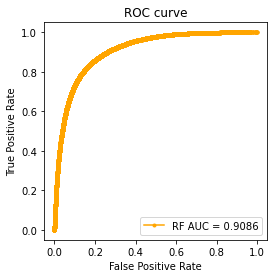

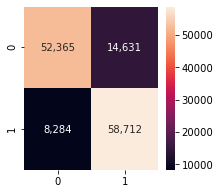

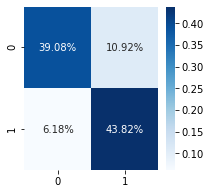

In [24]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]

rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# TPR 99% DB size

# pep length . detectability . freq

In [50]:
test_data.shape

torch.Size([133992, 30])

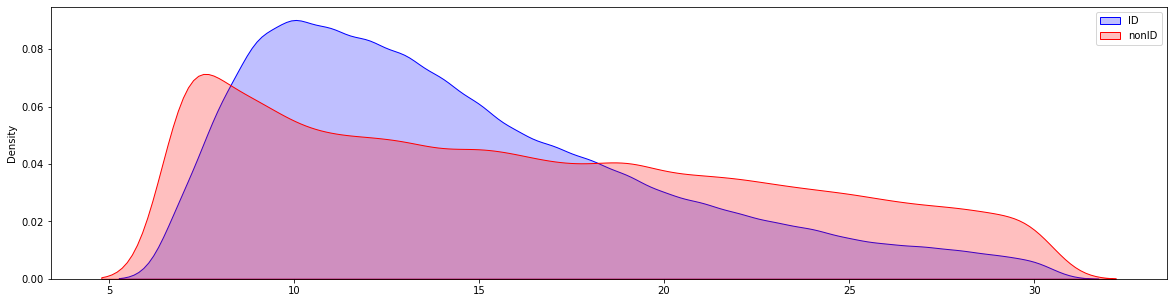

In [29]:
p = df_detect_peptide_test.loc[df_detect_peptide_test.ID==1]
n = df_detect_peptide_test.loc[df_detect_peptide_test.ID==0]
pl = p.PEP.apply(lambda x: len(x)).values
nl = n.PEP.apply(lambda x: len(x)).values
plt.figure(figsize=(20,5))
sns.kdeplot(pl, shade=True, color='blue')
sns.kdeplot(nl, shade=True, color='red')
plt.legend(['ID', 'nonID'])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa0c58c0fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa0c58e85c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa0c58c0d30>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa0c58e8b70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa0c58e8e48>],
 'means': []}

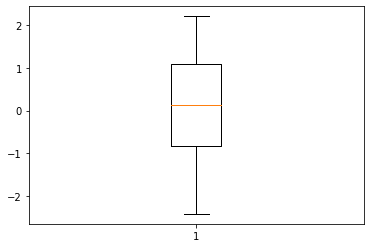

In [32]:
plt.boxplot(probs)

# bias

In [15]:
for num_model in range(4):
    bias_net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(bias_net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        bias_net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=bias_net(seq1)
                output2=bias_net(seq2)
                output3=bias_net.trainModel(seq1)
                output4=bias_net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        bias_net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,bias_net)
            test_acc=evaluate_accuracy(val_iter,bias_net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        to_log(results)
        if test_acc>best_acc:
            best_acc=test_acc
            torch.save({"best_acc":best_acc,"model":bias_net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/bias{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 142.78783, loss1: 1.14326, loss2_3: 141.64457
	train_acc: 0.7781, test_acc: 0.7785325287017957, time: 177.52
best_acc: 0.7785325287017957
epoch: 2, loss: 121.54200, loss1: 0.91405, loss2_3: 120.62796
	train_acc: 0.7883, test_acc: 0.7885855166323227, time: 176.81
best_acc: 0.7885855166323227
epoch: 3, loss: 117.12926, loss1: 0.88811, loss2_3: 116.24115
	train_acc: 0.7895, test_acc: 0.7895643214601119, time: 177.04
best_acc: 0.7895643214601119
epoch: 4, loss: 114.99770, loss1: 0.86840, loss2_3: 114.12930
	train_acc: 0.7968, test_acc: 0.7981527818663526, time: 178.19
best_acc: 0.7981527818663526
epoch: 5, loss: 113.52371, loss1: 0.85319, loss2_3: 112.67052
	train_acc: 0.8011, test_acc: 0.8010523991757433, time: 176.65
best_acc: 0.8010523991757433
epoch: 6, loss: 112.62694, loss1: 0.84373, loss2_3: 111.78321
	train_acc: 0.8017, test_acc: 0.8014498086546953, time: 176.45
best_acc: 0.8014498086546953
epoch: 7, loss: 111.85323, loss1: 0.83641, loss2_3: 111.01682
	train_acc: 0.

epoch: 58, loss: 103.35741, loss1: 0.77304, loss2_3: 102.58437
	train_acc: 0.8224, test_acc: 0.8206579334707095, time: 322.27
epoch: 59, loss: 103.30400, loss1: 0.77269, loss2_3: 102.53132
	train_acc: 0.8221, test_acc: 0.8201354136002355, time: 324.36
epoch: 60, loss: 103.37046, loss1: 0.77313, loss2_3: 102.59734
	train_acc: 0.8234, test_acc: 0.82057697968796, time: 326.29
epoch: 61, loss: 103.31324, loss1: 0.77280, loss2_3: 102.54044
	train_acc: 0.8214, test_acc: 0.8190094200765381, time: 323.58
epoch: 62, loss: 103.27975, loss1: 0.77320, loss2_3: 102.50655
	train_acc: 0.8196, test_acc: 0.8172578745952311, time: 323.02
epoch: 63, loss: 103.26447, loss1: 0.77296, loss2_3: 102.49151
	train_acc: 0.8229, test_acc: 0.8201942890785988, time: 323.69
epoch: 64, loss: 103.19983, loss1: 0.77162, loss2_3: 102.42820
	train_acc: 0.8222, test_acc: 0.8198042390344421, time: 322.30
epoch: 65, loss: 103.19659, loss1: 0.77266, loss2_3: 102.42393
	train_acc: 0.8229, test_acc: 0.8206064174271416, time: 3

epoch: 117, loss: 101.92761, loss1: 0.76488, loss2_3: 101.16273
	train_acc: 0.8255, test_acc: 0.8217397703856344, time: 129.86
epoch: 118, loss: 102.03149, loss1: 0.76572, loss2_3: 101.26577
	train_acc: 0.8243, test_acc: 0.8209891080365028, time: 130.01
epoch: 119, loss: 102.01312, loss1: 0.76496, loss2_3: 101.24815
	train_acc: 0.8215, test_acc: 0.8176184869002061, time: 129.99
epoch: 120, loss: 102.03106, loss1: 0.76500, loss2_3: 101.26607
	train_acc: 0.8252, test_acc: 0.8222696496909038, time: 129.97
epoch: 121, loss: 101.91182, loss1: 0.76377, loss2_3: 101.14806
	train_acc: 0.8255, test_acc: 0.8217103326464528, time: 129.95
epoch: 122, loss: 101.84762, loss1: 0.76661, loss2_3: 101.08102
	train_acc: 0.8254, test_acc: 0.8219090373859288, time: 130.06
epoch: 123, loss: 101.83573, loss1: 0.76458, loss2_3: 101.07115
	train_acc: 0.8254, test_acc: 0.8219826317338829, time: 129.96
epoch: 124, loss: 101.85931, loss1: 0.76501, loss2_3: 101.09430
	train_acc: 0.8245, test_acc: 0.821298204297909

epoch: 177, loss: 101.30881, loss1: 0.76072, loss2_3: 100.54809
	train_acc: 0.8262, test_acc: 0.8219458345599058, time: 130.27
epoch: 178, loss: 101.29007, loss1: 0.76253, loss2_3: 100.52755
	train_acc: 0.8253, test_acc: 0.8209081542537533, time: 130.33
epoch: 179, loss: 101.33209, loss1: 0.76162, loss2_3: 100.57046
	train_acc: 0.8273, test_acc: 0.8233441271710332, time: 130.13
best_acc: 0.8233441271710332
epoch: 180, loss: 101.41236, loss1: 0.76193, loss2_3: 100.65043
	train_acc: 0.8273, test_acc: 0.8231380629967618, time: 130.18
epoch: 181, loss: 101.30817, loss1: 0.76281, loss2_3: 100.54536
	train_acc: 0.8267, test_acc: 0.8231748601707389, time: 130.04
epoch: 182, loss: 101.33723, loss1: 0.76286, loss2_3: 100.57436
	train_acc: 0.8263, test_acc: 0.8219826317338829, time: 130.16
epoch: 183, loss: 101.29965, loss1: 0.76204, loss2_3: 100.53761
	train_acc: 0.8271, test_acc: 0.8229099205181042, time: 130.06
epoch: 184, loss: 101.27696, loss1: 0.75965, loss2_3: 100.51731
	train_acc: 0.8265

epoch: 238, loss: 100.95450, loss1: 0.75996, loss2_3: 100.19454
	train_acc: 0.8264, test_acc: 0.8213570797762731, time: 130.14
epoch: 239, loss: 100.97739, loss1: 0.75989, loss2_3: 100.21750
	train_acc: 0.8275, test_acc: 0.8224462761259935, time: 129.98
epoch: 240, loss: 101.01901, loss1: 0.76162, loss2_3: 100.25740
	train_acc: 0.8270, test_acc: 0.8217544892552252, time: 130.12
epoch: 241, loss: 100.92570, loss1: 0.75996, loss2_3: 100.16574
	train_acc: 0.8259, test_acc: 0.8208345599057992, time: 129.97
epoch: 242, loss: 101.00394, loss1: 0.75914, loss2_3: 100.24479
	train_acc: 0.8265, test_acc: 0.8211510156020018, time: 130.15
epoch: 243, loss: 101.00547, loss1: 0.75902, loss2_3: 100.24645
	train_acc: 0.8268, test_acc: 0.8220635855166323, time: 130.07
epoch: 244, loss: 100.88786, loss1: 0.75892, loss2_3: 100.12894
	train_acc: 0.8281, test_acc: 0.8231675007359435, time: 130.13
epoch: 245, loss: 100.88038, loss1: 0.76094, loss2_3: 100.11943
	train_acc: 0.8276, test_acc: 0.822343244038857

epoch: 45, loss: 103.90145, loss1: 0.77411, loss2_3: 103.12734
	train_acc: 0.8189, test_acc: 0.8169782160730056, time: 130.47
epoch: 46, loss: 103.94950, loss1: 0.77681, loss2_3: 103.17269
	train_acc: 0.8212, test_acc: 0.8188548719458345, time: 130.58
epoch: 47, loss: 103.85137, loss1: 0.77512, loss2_3: 103.07625
	train_acc: 0.8218, test_acc: 0.8198115984692376, time: 130.48
epoch: 48, loss: 103.77257, loss1: 0.77558, loss2_3: 102.99699
	train_acc: 0.8214, test_acc: 0.8197380041212835, time: 130.55
epoch: 49, loss: 103.65262, loss1: 0.77423, loss2_3: 102.87839
	train_acc: 0.8207, test_acc: 0.8187297615543127, time: 130.55
epoch: 50, loss: 103.58069, loss1: 0.77398, loss2_3: 102.80671
	train_acc: 0.8204, test_acc: 0.8197821607300559, time: 130.25
epoch: 51, loss: 103.54181, loss1: 0.77540, loss2_3: 102.76641
	train_acc: 0.8197, test_acc: 0.8175596114218429, time: 130.16
epoch: 52, loss: 103.52637, loss1: 0.77368, loss2_3: 102.75269
	train_acc: 0.8225, test_acc: 0.8202973211657345, time:

epoch: 105, loss: 101.88666, loss1: 0.76497, loss2_3: 101.12169
	train_acc: 0.8250, test_acc: 0.8209596702973212, time: 130.21
epoch: 106, loss: 101.90090, loss1: 0.76509, loss2_3: 101.13581
	train_acc: 0.8234, test_acc: 0.8199587871651457, time: 130.35
epoch: 107, loss: 101.90758, loss1: 0.76574, loss2_3: 101.14185
	train_acc: 0.8255, test_acc: 0.8215189873417722, time: 130.21
epoch: 108, loss: 101.83997, loss1: 0.76395, loss2_3: 101.07602
	train_acc: 0.8234, test_acc: 0.8190094200765381, time: 130.29
epoch: 109, loss: 101.78766, loss1: 0.76490, loss2_3: 101.02276
	train_acc: 0.8244, test_acc: 0.8210185457756844, time: 129.88
epoch: 110, loss: 101.81160, loss1: 0.76422, loss2_3: 101.04738
	train_acc: 0.8219, test_acc: 0.8178245510744775, time: 130.05
epoch: 111, loss: 101.87925, loss1: 0.76548, loss2_3: 101.11377
	train_acc: 0.8250, test_acc: 0.8208566382101855, time: 129.99
epoch: 112, loss: 101.74686, loss1: 0.76539, loss2_3: 100.98148
	train_acc: 0.8256, test_acc: 0.822291727995289

epoch: 165, loss: 101.28003, loss1: 0.76116, loss2_3: 100.51888
	train_acc: 0.8259, test_acc: 0.8210038269060936, time: 130.05
epoch: 166, loss: 101.23028, loss1: 0.76115, loss2_3: 100.46913
	train_acc: 0.8268, test_acc: 0.8224315572564027, time: 130.12
epoch: 167, loss: 101.26552, loss1: 0.76224, loss2_3: 100.50328
	train_acc: 0.8265, test_acc: 0.8210406240800706, time: 129.91
epoch: 168, loss: 101.19612, loss1: 0.76196, loss2_3: 100.43417
	train_acc: 0.8261, test_acc: 0.8217912864292022, time: 130.15
epoch: 169, loss: 101.12038, loss1: 0.76093, loss2_3: 100.35945
	train_acc: 0.8266, test_acc: 0.8225125110391522, time: 130.14
epoch: 170, loss: 101.15430, loss1: 0.76127, loss2_3: 100.39303
	train_acc: 0.8269, test_acc: 0.8224021195172211, time: 130.20
epoch: 171, loss: 101.23286, loss1: 0.76082, loss2_3: 100.47204
	train_acc: 0.8268, test_acc: 0.8214159552546364, time: 130.01
epoch: 172, loss: 101.15996, loss1: 0.76137, loss2_3: 100.39859
	train_acc: 0.8259, test_acc: 0.820834559905799

epoch: 226, loss: 100.79094, loss1: 0.75968, loss2_3: 100.03125
	train_acc: 0.8281, test_acc: 0.8227995289961731, time: 130.57
epoch: 227, loss: 100.79698, loss1: 0.75919, loss2_3: 100.03779
	train_acc: 0.8273, test_acc: 0.8221592581689726, time: 138.14
epoch: 228, loss: 100.76755, loss1: 0.75924, loss2_3: 100.00832
	train_acc: 0.8266, test_acc: 0.8214380335590227, time: 130.52
epoch: 229, loss: 100.75790, loss1: 0.75880, loss2_3: 99.99910
	train_acc: 0.8234, test_acc: 0.8177362378569326, time: 130.64
epoch: 230, loss: 100.65458, loss1: 0.75800, loss2_3: 99.89658
	train_acc: 0.8278, test_acc: 0.8211804533411834, time: 130.34
epoch: 231, loss: 100.78060, loss1: 0.75726, loss2_3: 100.02334
	train_acc: 0.8280, test_acc: 0.8216882543420665, time: 130.39
epoch: 232, loss: 100.77439, loss1: 0.75816, loss2_3: 100.01623
	train_acc: 0.8269, test_acc: 0.8206211362967324, time: 130.19
epoch: 233, loss: 100.68134, loss1: 0.75772, loss2_3: 99.92362
	train_acc: 0.8276, test_acc: 0.8222696496909038, 

epoch: 34, loss: 104.47052, loss1: 0.77816, loss2_3: 103.69237
	train_acc: 0.8190, test_acc: 0.8173241095083897, time: 130.16
epoch: 35, loss: 104.28884, loss1: 0.77854, loss2_3: 103.51030
	train_acc: 0.8211, test_acc: 0.8194877833382396, time: 130.34
best_acc: 0.8194877833382396
epoch: 36, loss: 104.26183, loss1: 0.77718, loss2_3: 103.48465
	train_acc: 0.8204, test_acc: 0.8190094200765381, time: 130.18
epoch: 37, loss: 104.30561, loss1: 0.77880, loss2_3: 103.52681
	train_acc: 0.8213, test_acc: 0.8200618192522814, time: 130.25
best_acc: 0.8200618192522814
epoch: 38, loss: 104.20135, loss1: 0.77770, loss2_3: 103.42365
	train_acc: 0.8207, test_acc: 0.819495142773035, time: 130.27
epoch: 39, loss: 104.17080, loss1: 0.77815, loss2_3: 103.39265
	train_acc: 0.8206, test_acc: 0.8189431851633795, time: 130.42
epoch: 40, loss: 104.11611, loss1: 0.77585, loss2_3: 103.34025
	train_acc: 0.8205, test_acc: 0.8188180747718575, time: 130.75
epoch: 41, loss: 103.99165, loss1: 0.77551, loss2_3: 103.2161

epoch: 93, loss: 102.47864, loss1: 0.76659, loss2_3: 101.71205
	train_acc: 0.8250, test_acc: 0.8216514571680895, time: 130.55
epoch: 94, loss: 102.37143, loss1: 0.76644, loss2_3: 101.60499
	train_acc: 0.8251, test_acc: 0.8219605534294966, time: 130.48
epoch: 95, loss: 102.41853, loss1: 0.76737, loss2_3: 101.65116
	train_acc: 0.8250, test_acc: 0.8209081542537533, time: 130.61
epoch: 96, loss: 102.40817, loss1: 0.76880, loss2_3: 101.63938
	train_acc: 0.8250, test_acc: 0.8218428024727701, time: 130.39
epoch: 97, loss: 102.41755, loss1: 0.76656, loss2_3: 101.65099
	train_acc: 0.8248, test_acc: 0.8210259052104798, time: 130.52
epoch: 98, loss: 102.39605, loss1: 0.76707, loss2_3: 101.62899
	train_acc: 0.8240, test_acc: 0.8210994995584339, time: 130.44
epoch: 99, loss: 102.32390, loss1: 0.76808, loss2_3: 101.55582
	train_acc: 0.8225, test_acc: 0.8194068295554902, time: 130.46
epoch: 100, loss: 102.32241, loss1: 0.76678, loss2_3: 101.55563
	train_acc: 0.8250, test_acc: 0.8216220194289079, time

epoch: 153, loss: 101.60101, loss1: 0.76299, loss2_3: 100.83802
	train_acc: 0.8245, test_acc: 0.8196276125993524, time: 130.88
epoch: 154, loss: 101.69616, loss1: 0.76405, loss2_3: 100.93212
	train_acc: 0.8257, test_acc: 0.8213497203414778, time: 130.75
epoch: 155, loss: 101.76706, loss1: 0.76349, loss2_3: 101.00357
	train_acc: 0.8262, test_acc: 0.8220267883426553, time: 130.76
epoch: 156, loss: 101.71140, loss1: 0.76360, loss2_3: 100.94780
	train_acc: 0.8264, test_acc: 0.8222843685604946, time: 130.54
epoch: 157, loss: 101.59357, loss1: 0.76358, loss2_3: 100.82999
	train_acc: 0.8257, test_acc: 0.8211583750367972, time: 130.55
epoch: 158, loss: 101.55190, loss1: 0.76399, loss2_3: 100.78791
	train_acc: 0.8256, test_acc: 0.8214012363850456, time: 130.42
epoch: 159, loss: 101.63300, loss1: 0.76414, loss2_3: 100.86885
	train_acc: 0.8267, test_acc: 0.8220267883426553, time: 130.64
epoch: 160, loss: 101.60579, loss1: 0.76253, loss2_3: 100.84326
	train_acc: 0.8263, test_acc: 0.821548425080953

epoch: 214, loss: 101.18654, loss1: 0.76114, loss2_3: 100.42539
	train_acc: 0.8264, test_acc: 0.8208787165145717, time: 130.40
epoch: 215, loss: 101.20632, loss1: 0.76209, loss2_3: 100.44423
	train_acc: 0.8271, test_acc: 0.8207094495142773, time: 130.51
epoch: 216, loss: 101.24769, loss1: 0.76254, loss2_3: 100.48515
	train_acc: 0.8274, test_acc: 0.8222770091256991, time: 130.25
epoch: 217, loss: 101.19420, loss1: 0.76313, loss2_3: 100.43106
	train_acc: 0.8268, test_acc: 0.8217986458639976, time: 130.31
epoch: 218, loss: 101.27371, loss1: 0.76218, loss2_3: 100.51152
	train_acc: 0.8263, test_acc: 0.8208860759493671, time: 130.35
epoch: 219, loss: 101.21841, loss1: 0.75963, loss2_3: 100.45878
	train_acc: 0.8260, test_acc: 0.8210038269060936, time: 130.33
epoch: 220, loss: 101.26337, loss1: 0.76325, loss2_3: 100.50012
	train_acc: 0.8269, test_acc: 0.8219237562555196, time: 130.24
epoch: 221, loss: 101.25608, loss1: 0.76246, loss2_3: 100.49362
	train_acc: 0.8270, test_acc: 0.821850161907565

epoch: 22, loss: 105.60418, loss1: 0.78633, loss2_3: 104.81784
	train_acc: 0.8187, test_acc: 0.8180968501619076, time: 130.52
best_acc: 0.8180968501619076
epoch: 23, loss: 105.56834, loss1: 0.78629, loss2_3: 104.78205
	train_acc: 0.8174, test_acc: 0.816102443332352, time: 130.55
epoch: 24, loss: 105.35876, loss1: 0.78600, loss2_3: 104.57276
	train_acc: 0.8173, test_acc: 0.816661760376803, time: 130.47
epoch: 25, loss: 105.20278, loss1: 0.78534, loss2_3: 104.41744
	train_acc: 0.8192, test_acc: 0.8183691492493377, time: 130.55
best_acc: 0.8183691492493377
epoch: 26, loss: 105.15422, loss1: 0.78377, loss2_3: 104.37045
	train_acc: 0.8189, test_acc: 0.8174345010303209, time: 132.82
epoch: 27, loss: 104.96610, loss1: 0.78333, loss2_3: 104.18277
	train_acc: 0.8187, test_acc: 0.8171695613776861, time: 135.11
epoch: 28, loss: 104.94168, loss1: 0.78127, loss2_3: 104.16042
	train_acc: 0.8199, test_acc: 0.8187518398586988, time: 134.90
best_acc: 0.8187518398586988
epoch: 29, loss: 104.85624, loss1

epoch: 80, loss: 102.48826, loss1: 0.76749, loss2_3: 101.72077
	train_acc: 0.8251, test_acc: 0.8213055637327054, time: 130.61
epoch: 81, loss: 102.35151, loss1: 0.76868, loss2_3: 101.58283
	train_acc: 0.8239, test_acc: 0.8202605239917574, time: 130.76
epoch: 82, loss: 102.40092, loss1: 0.76863, loss2_3: 101.63229
	train_acc: 0.8249, test_acc: 0.8216293788637032, time: 130.75
epoch: 83, loss: 102.35590, loss1: 0.76819, loss2_3: 101.58771
	train_acc: 0.8241, test_acc: 0.8212466882543421, time: 130.85
epoch: 84, loss: 102.28422, loss1: 0.76700, loss2_3: 101.51722
	train_acc: 0.8215, test_acc: 0.8184206652929055, time: 130.65
epoch: 85, loss: 102.28581, loss1: 0.76609, loss2_3: 101.51972
	train_acc: 0.8246, test_acc: 0.821371798645864, time: 130.64
epoch: 86, loss: 102.34311, loss1: 0.76758, loss2_3: 101.57552
	train_acc: 0.8249, test_acc: 0.8215999411245216, time: 130.55
epoch: 87, loss: 102.24240, loss1: 0.76648, loss2_3: 101.47592
	train_acc: 0.8249, test_acc: 0.8209817486017074, time: 

epoch: 140, loss: 101.49719, loss1: 0.76267, loss2_3: 100.73453
	train_acc: 0.8209, test_acc: 0.8161098027671475, time: 130.54
epoch: 141, loss: 101.50694, loss1: 0.76295, loss2_3: 100.74399
	train_acc: 0.8259, test_acc: 0.8210627023844569, time: 130.58
epoch: 142, loss: 101.35845, loss1: 0.76253, loss2_3: 100.59592
	train_acc: 0.8185, test_acc: 0.8142993818074772, time: 130.55
epoch: 143, loss: 101.54094, loss1: 0.76326, loss2_3: 100.77767
	train_acc: 0.8262, test_acc: 0.8218575213423609, time: 130.56
epoch: 144, loss: 101.40113, loss1: 0.76375, loss2_3: 100.63739
	train_acc: 0.8263, test_acc: 0.8221371798645865, time: 130.52
epoch: 145, loss: 101.44193, loss1: 0.76281, loss2_3: 100.67911
	train_acc: 0.8265, test_acc: 0.8220194289078598, time: 130.62
epoch: 146, loss: 101.44820, loss1: 0.76323, loss2_3: 100.68497
	train_acc: 0.8264, test_acc: 0.8219531939947012, time: 130.68
epoch: 147, loss: 101.35296, loss1: 0.76292, loss2_3: 100.59004
	train_acc: 0.8242, test_acc: 0.819561377686193

epoch: 201, loss: 100.92198, loss1: 0.75912, loss2_3: 100.16286
	train_acc: 0.8242, test_acc: 0.819296438033559, time: 144.42
epoch: 202, loss: 100.86127, loss1: 0.76019, loss2_3: 100.10108
	train_acc: 0.8262, test_acc: 0.8211142184280247, time: 144.45
epoch: 203, loss: 100.87276, loss1: 0.76010, loss2_3: 100.11267
	train_acc: 0.8276, test_acc: 0.8223138062996762, time: 141.31
epoch: 204, loss: 100.79865, loss1: 0.75971, loss2_3: 100.03894
	train_acc: 0.8273, test_acc: 0.8214674712982043, time: 130.72
epoch: 205, loss: 100.82685, loss1: 0.75934, loss2_3: 100.06751
	train_acc: 0.8282, test_acc: 0.8222254930821313, time: 130.81
epoch: 206, loss: 100.89180, loss1: 0.75981, loss2_3: 100.13199
	train_acc: 0.8272, test_acc: 0.8217324109508389, time: 130.71
epoch: 207, loss: 100.81900, loss1: 0.75789, loss2_3: 100.06111
	train_acc: 0.8263, test_acc: 0.8209670297321165, time: 130.62
epoch: 208, loss: 100.85686, loss1: 0.75871, loss2_3: 100.09815
	train_acc: 0.8277, test_acc: 0.8226817780394465

In [ ]:
0.8230276714748307, 0.8218795996467472, 0.8216882543420665, 0.8190830144244922

Test Accuracy: 0.818153322586423
              precision    recall  f1-score   support

           0       0.88      0.73      0.80     66996
           1       0.77      0.90      0.83     66996

    accuracy                           0.82    133992
   macro avg       0.83      0.82      0.82    133992
weighted avg       0.83      0.82      0.82    133992

rf auc : 0.9063554047661546


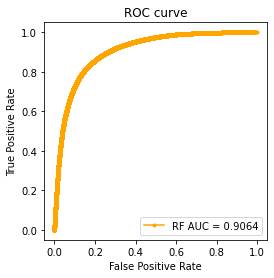

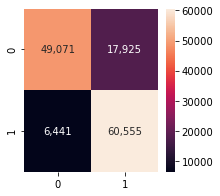

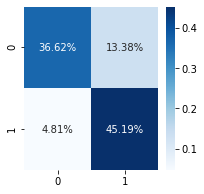

In [16]:
test_acc = evaluate_accuracy(test_iter,bias_net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, bias_net)
print(classification_report(test_label, y_pred))

# AUC
probs = np.array(pred_prob(test_iter, bias_net))[:, 1]

rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()